# CS-433 Project 1: ML Higgs 
Changling Li, Julian Blackwell, Luca Bataillard

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
from implementations import *

In [3]:
DATA_TRAIN_PATH = '../data/train.csv'
y_train, x_train, ids_train = load_csv_data(DATA_TRAIN_PATH)
column_names = np.genfromtxt(DATA_TRAIN_PATH, delimiter=",", dtype=str)[0, 2:]

## Exploratory data analysis

### Step 1: Inspecting the labels

We begin our data analysis by inspecting the `y` array of labels. According to the documentation, all labels are $-1$ for background 'b' and $1$ is for signal 's'. We check this below:

In [4]:
((y_train == 1) | (y_train == -1)).all()

True

### Step 2: Inspecting the features

We first read appendix B of the original Higgs paper and discover several key points:
* All variables are floating point and continuous, apart from `PRI_jet_num`, which ranges in $\{0, 1, 2, 3\}$
* Undefined values are denoted by the value $-999.0$

We inspect the features of `tx` to confirm these claims. We can see that `PRI_jet_num` corresponds to column 22. We decide to do no further processing to this variable and treat it as continuous. We notice several undefinded variables.

In [5]:
N, D = x_train.shape
print(f"Number of rows: {N}")
print(f"Number of columns: {D}")

Number of rows: 250000
Number of columns: 30


In [6]:
for i, colname in enumerate(column_names):
    col = x_train[:5, i]
    print(f"{i:2} - {colname:30s}: {col}")

 0 - DER_mass_MMC                  : [ 138.47   160.937 -999.     143.905  175.864]
 1 - DER_mass_transverse_met_lep   : [ 51.655  68.768 162.172  81.417  16.915]
 2 - DER_mass_vis                  : [ 97.827 103.235 125.953  80.943 134.805]
 3 - DER_pt_h                      : [27.98  48.146 35.635  0.414 16.405]
 4 - DER_deltaeta_jet_jet          : [ 9.10e-01 -9.99e+02 -9.99e+02 -9.99e+02 -9.99e+02]
 5 - DER_mass_jet_jet              : [ 124.711 -999.    -999.    -999.    -999.   ]
 6 - DER_prodeta_jet_jet           : [   2.666 -999.    -999.    -999.    -999.   ]
 7 - DER_deltar_tau_lep            : [3.064 3.473 3.148 3.31  3.891]
 8 - DER_pt_tot                    : [41.928  2.078  9.336  0.414 16.405]
 9 - DER_sum_pt                    : [197.76  125.157 197.814  75.968  57.983]
10 - DER_pt_ratio_lep_tau          : [1.582 0.879 3.776 2.354 1.056]
11 - DER_met_phi_centrality        : [ 1.396  1.414  1.414 -1.285 -1.385]
12 - DER_lep_eta_centrality        : [ 2.00e-01 -9.99e+02 -9.9

### Step 3: Summary statistics

By computing the summary statistics on the data, we notice that undefined values are not present in all columns. However, in columns where they are present, they comprise a large proportion of the data. There are too many such rows to be simply discarded as outliers, so we will treat them as regular datapoints for the time being.

We also notice that each feature follows a very different distribution. To ease model computational cost and improve model performance, we will scale the dataset by subtracting the mean and dividing by the standard deviation. 

In [7]:
display_summary_statistics(x_train, column_names=column_names)

   Column                      |   Mean   |  Median  | Std dev  |   Max    |    Min   | # Undefined | % Undef 
 0-DER_mass_MMC                |  -49.023    105.012    406.345   1192.026   -999.000    38114.000     15.246
 1-DER_mass_transverse_met_lep |   49.240     46.524     35.345    690.075      0.000        0.000      0.000
 2-DER_mass_vis                |   81.182     73.752     40.829   1349.351      6.329        0.000      0.000
 3-DER_pt_h                    |   57.896     38.468     63.656   2834.999      0.000        0.000      0.000
 4-DER_deltaeta_jet_jet        | -708.421   -999.000    454.480      8.503   -999.000   177457.000     70.983
 5-DER_mass_jet_jet            | -601.237   -999.000    657.971   4974.979   -999.000   177457.000     70.983
 6-DER_prodeta_jet_jet         | -709.357   -999.000    453.019     16.690   -999.000   177457.000     70.983
 7-DER_deltar_tau_lep          |    2.373      2.492      0.783      5.684      0.208        0.000      0.000
 8-DER_pt

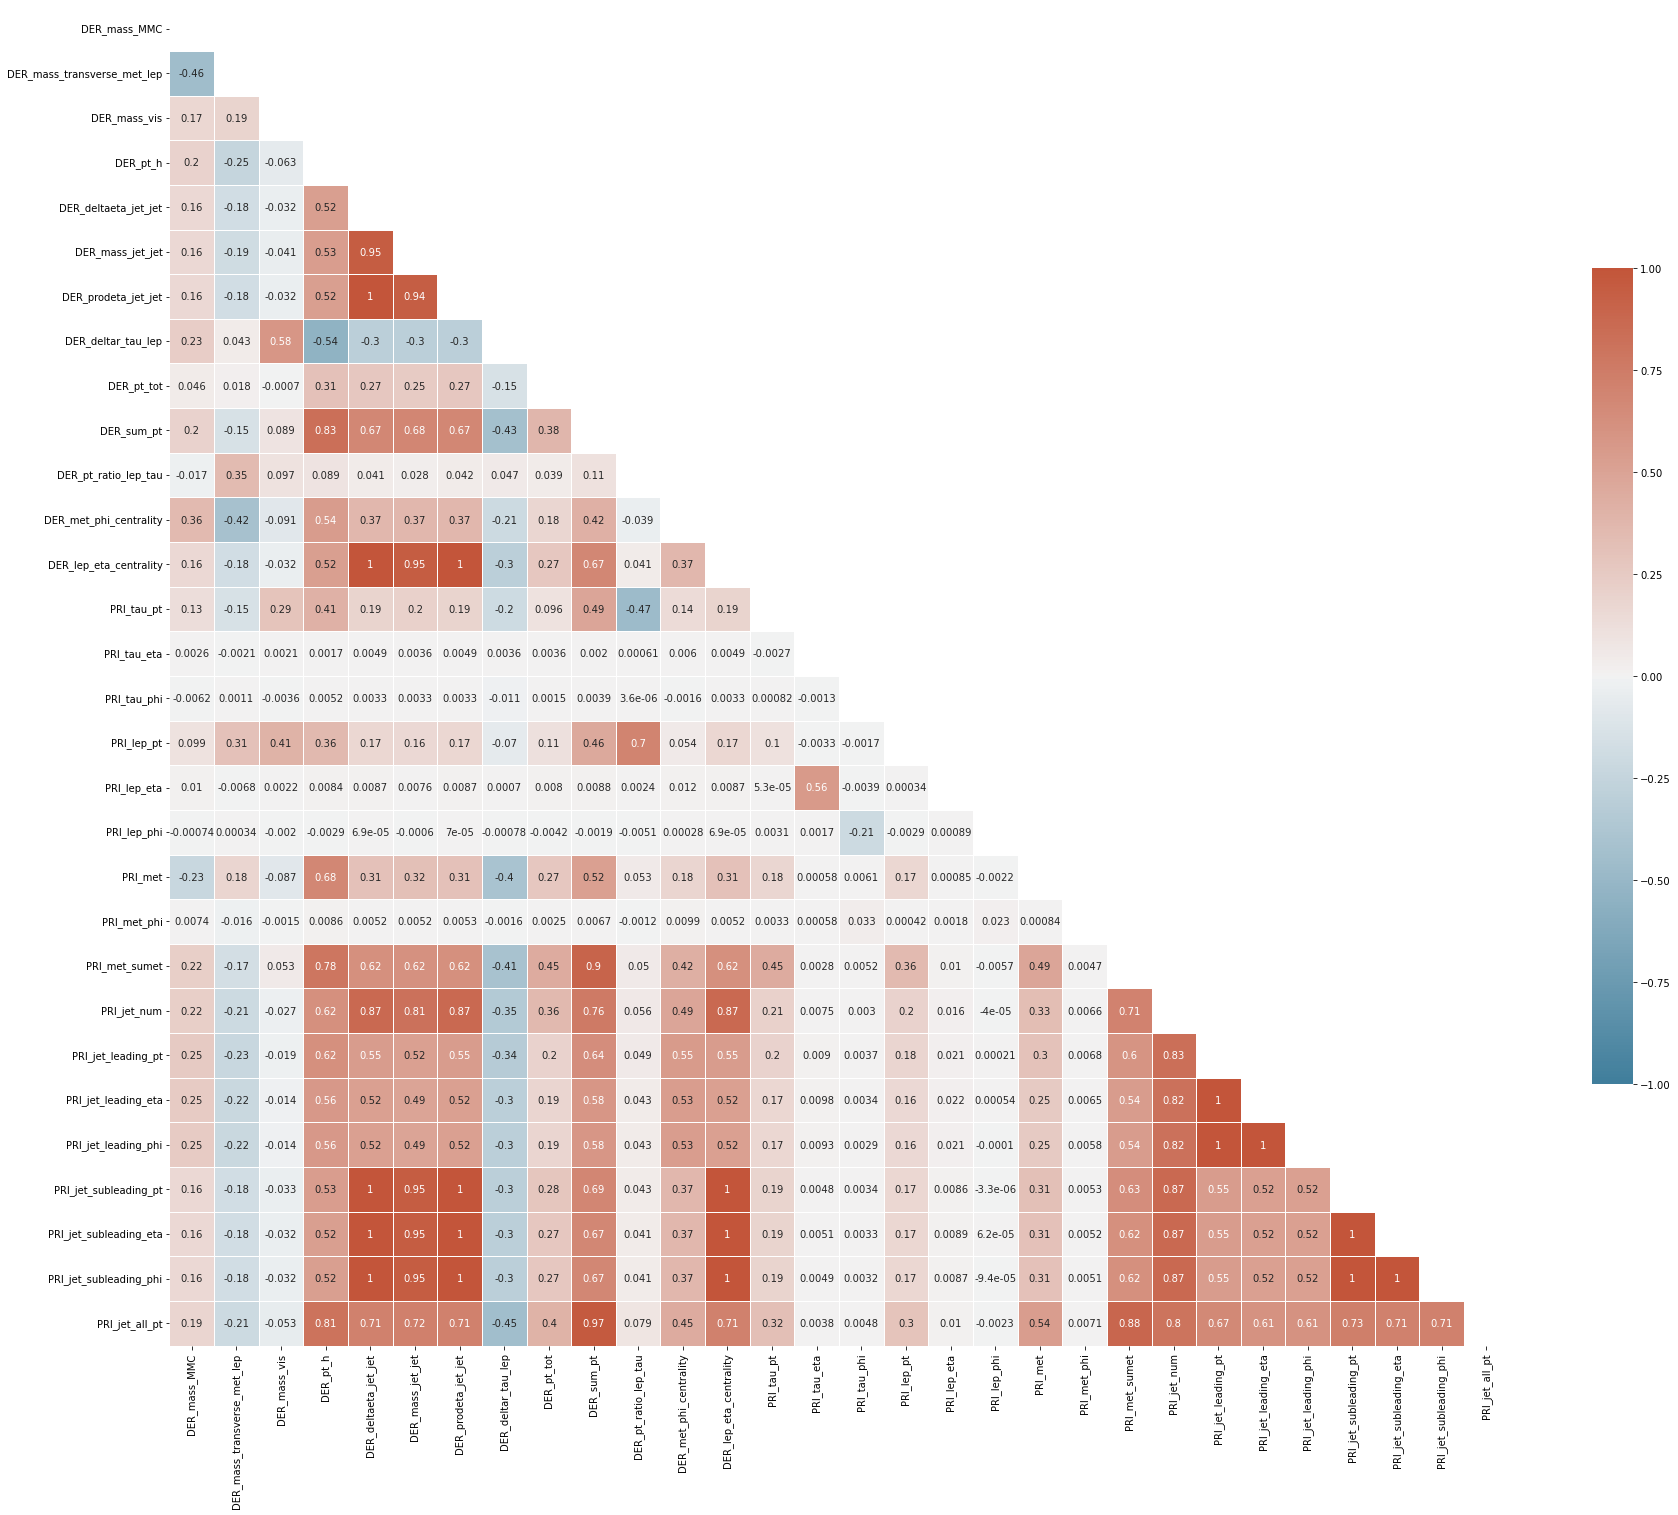

In [8]:
plot_corr_matrix(x_train, column_names)

## Feature processing

### Handling missing values

After initial data analysies, we notice that a small number of columns have over $70\%$ invalid values. We decide to discard such columns. 

Some other columns still have invalid values, we decide to replace the $-999$ by the mean of all non-invalid values in that column.

In [9]:
def handle_invalid(x, column_names=None):
    """Takes a dataset and a list of columns names. Removes columns with too many invalid values. 
    Replaces remaining invalid values with mean of its respective column."""

    invalid_value = -999.0
    invalid_threshold = 0.7

    # Remove columns with a pct of invalid values above 70%
    pct_undef = (x <= invalid_value).mean(axis=0)
    below_thresh = pct_undef < invalid_threshold

    print(f"{(~below_thresh).sum()} columns are above the invalid threshold. Removing", end="\n\t")
    if column_names is not None:
        print(*column_names[~below_thresh], sep="\n\t")
        column_names = column_names[below_thresh]

    x = x[:, below_thresh]

    # Replace -999 with mean value of remaining values for each column still in dataset
    for i in range(x.shape[1]):
        col = x[:, i]
        mean = col[col > invalid_value].mean()
        col[col <= invalid_value] = mean

    return x, column_names


x_train, column_names = handle_invalid(x_train, column_names)

7 columns are above the invalid threshold. Removing
	DER_deltaeta_jet_jet
	DER_mass_jet_jet
	DER_prodeta_jet_jet
	DER_lep_eta_centrality
	PRI_jet_subleading_pt
	PRI_jet_subleading_eta
	PRI_jet_subleading_phi


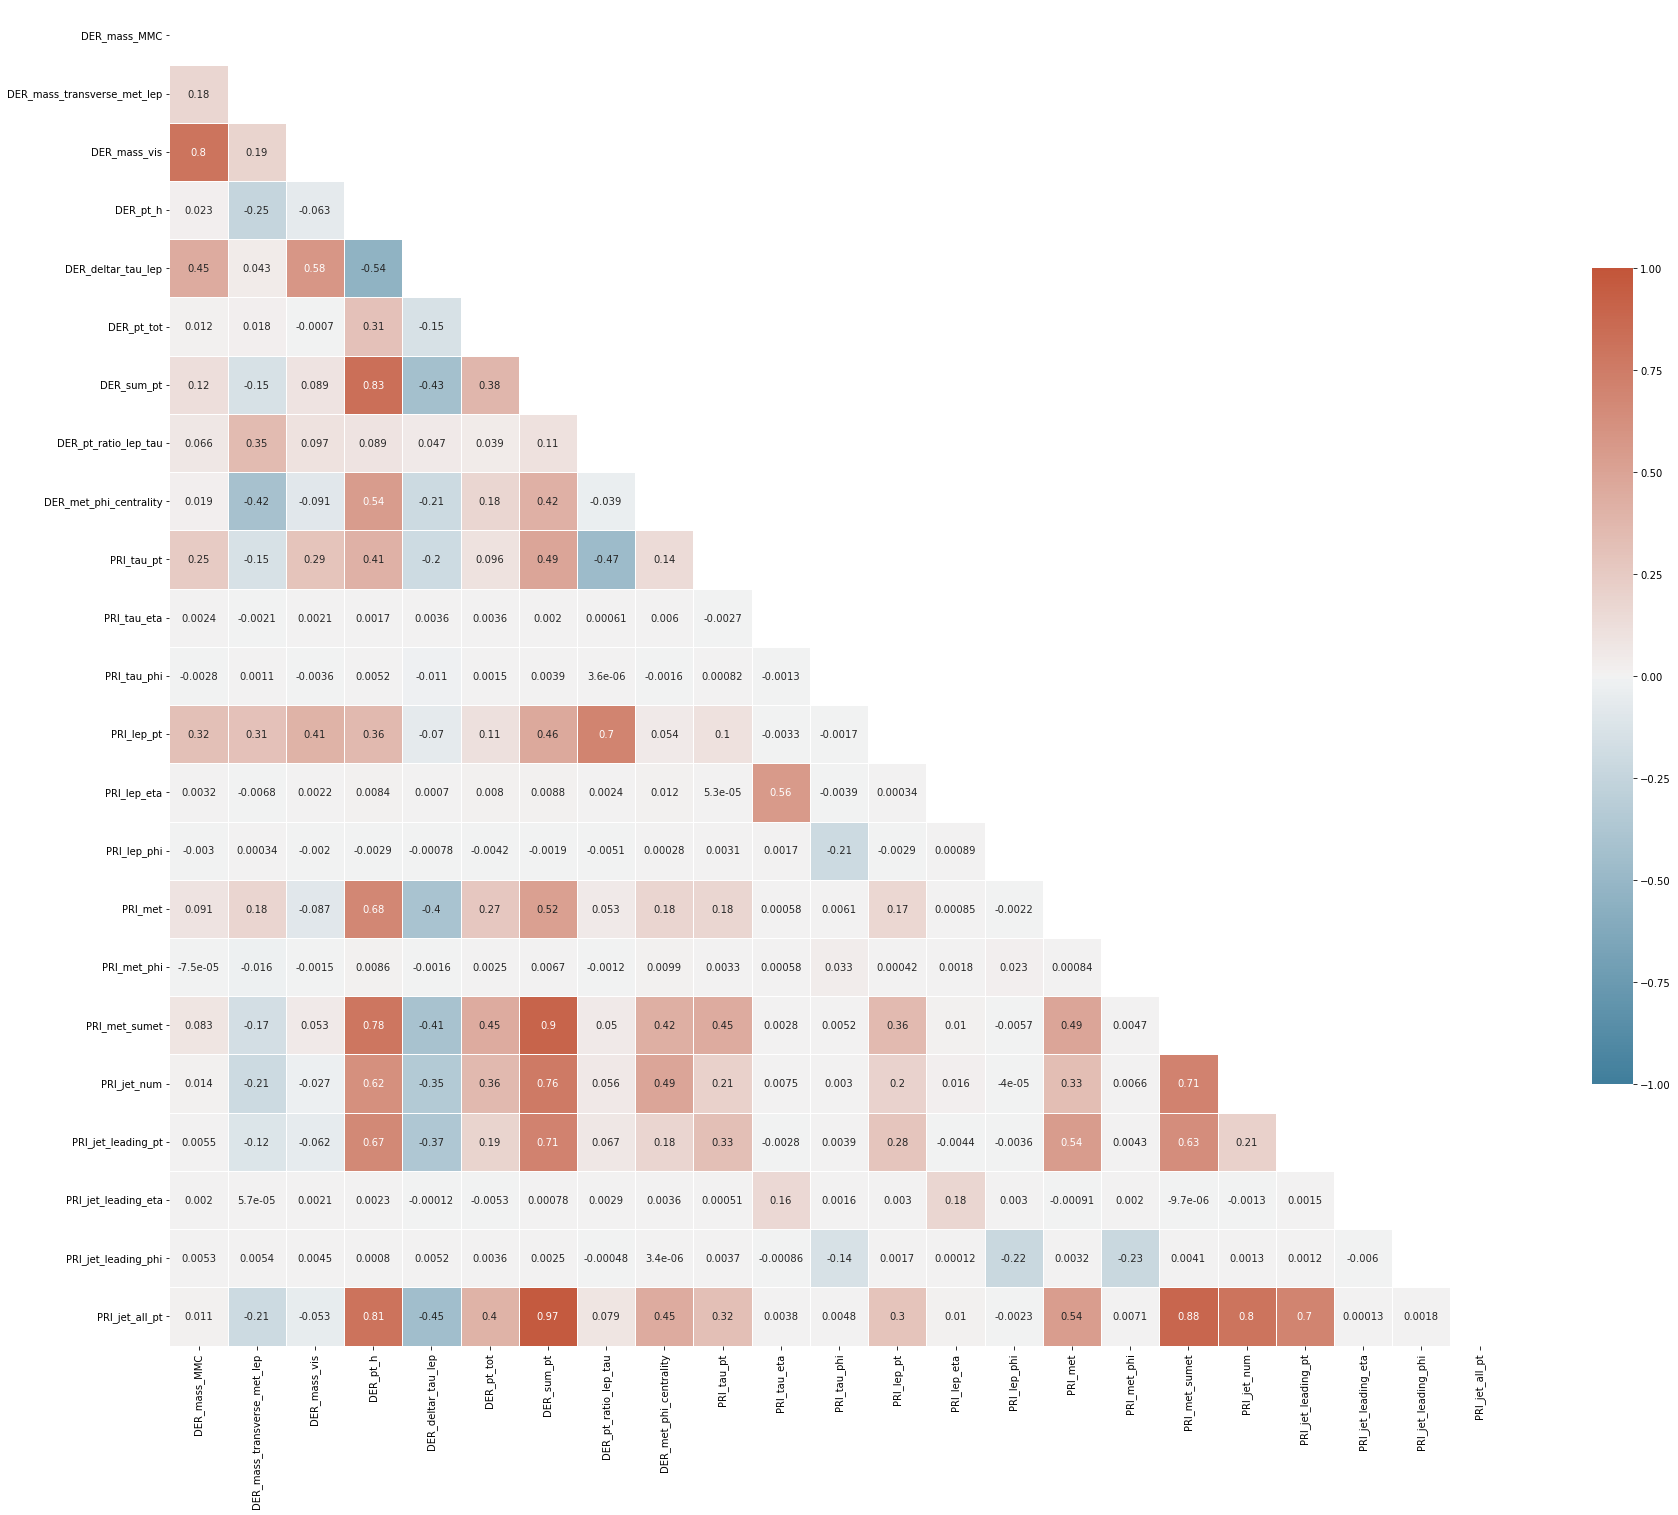

In [10]:
plot_corr_matrix(x_train, column_names)

### Removing features
We observe that some columns are very correlated with others so we decide to remove these

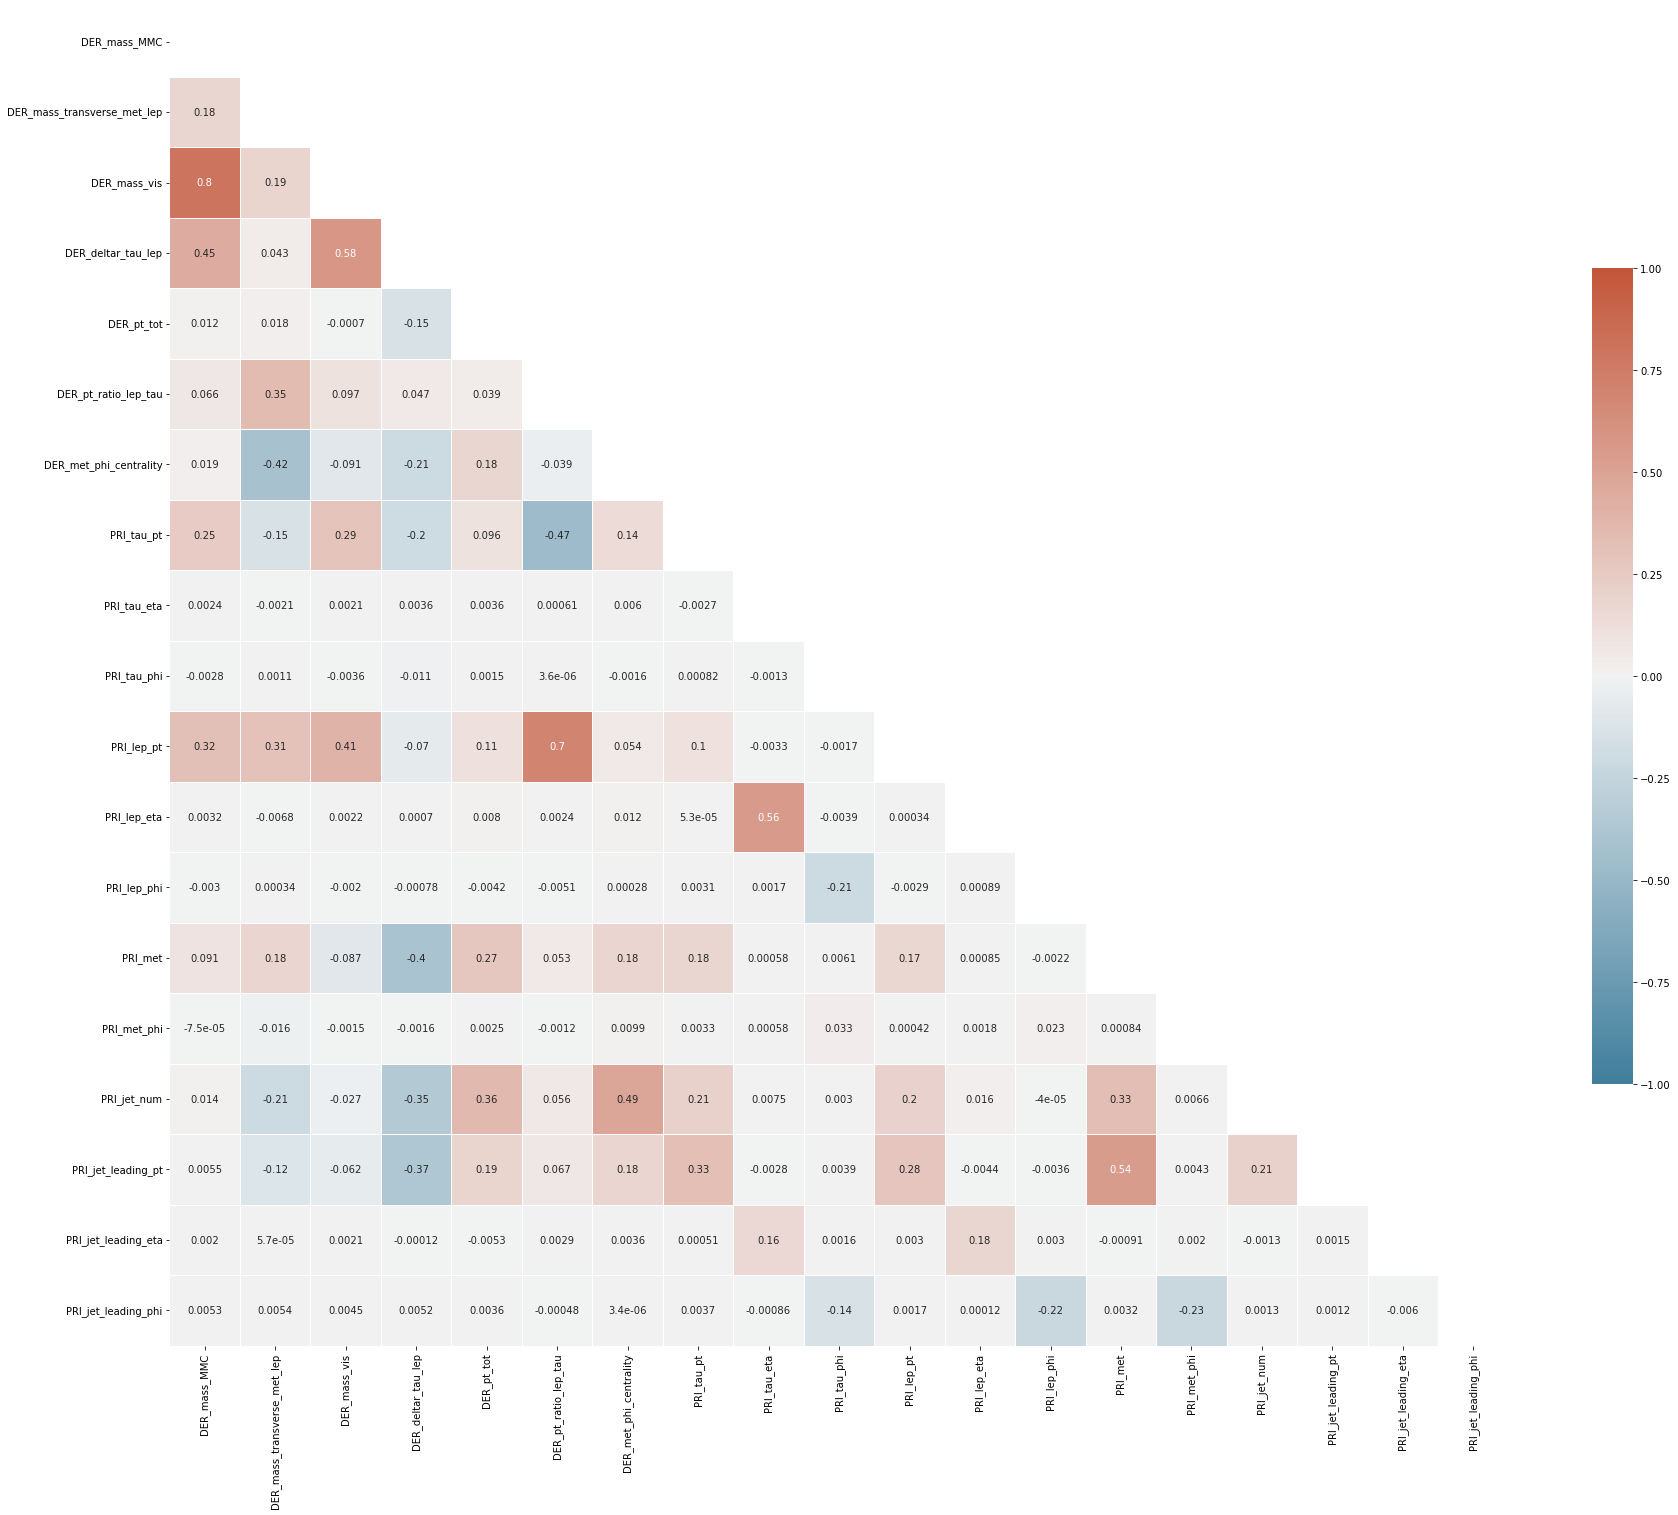

In [73]:
to_remove = ['DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet', 'PRI_jet_all_pt']
to_remove = [np.where(column_names == name)[0][0] for name in to_remove]
to_remove = np.array(to_remove)
res, res_names = np.delete(x_train, to_remove, axis=1), np.delete(column_names, to_remove)
plot_corr_matrix(res, res_names)

In [74]:
res_square = np.square(res)
res_cube = np.power(res, 3)
res_sc = res_square + res_cube
res_poly = np.append(res, res_square, axis=1)
res_poly = np.append(res_poly, res_cube, axis=1)

In [75]:
res_std, res_mean, res_dev = standardize(res_poly)

In [76]:
ry_train, rx_train = y_train[:split_point], res_std[:split_point]
ry_test, rx_test = y_train[split_point:], res_std[split_point:]
res_weights, _ = ridge_regression(ry_train, rx_train, 0.00005)
res_test = predict_labels(res_weights, rx_test)
len(res_test[res_test == ry_test]) / len(res_test)

0.7304

*TODO* 
1. Ajouter des sin et cos comme features (voir plus bas)
2. Ev. ajouter des degrés plus haut sur certains features
3. Supprimer des colonnes trop corellées entre elles


### Adding additonal features 

We decide to add 

In [11]:
def add_features(x, column_names, mean=None, std=None):
    
    N, D = x.shape
    
    # Create sin and cos variants of angular columns 
    ang_cols = ["PRI_tau_phi", "PRI_lep_phi", "PRI_met_phi", 
                "PRI_jet_leading_phi", "PRI_jet_subleading_phi"]
    ang_col_idx = np.isin(column_names, ang_cols).nonzero()[0]    
    
    
    pass

We then standardize the dataset by z-scoring the training set. We also save the mean and std so that we can reuse it to standardize the test set with the same distribution.

In [43]:
x_train_std, mean_train, std_train = standardize(x_train)

## Split data into training and testing data

In [44]:
split_point = int(x_train_std.shape[0] * 0.96)
y_training, x_training = y_train[:split_point], x_train_std[:split_point]
y_testing, x_testing = y_train[split_point:], x_train_std[split_point:]

## Model selection

Now that the data has been appropriately engineered, we decide to try out several models. When appropriate, we perform hyperparameter search using grid search and $5$-fold cross validation.

### Regularized logistic regression

In [ ]:
reg_logistic_regression_params = {
    'max_iters': [30],
    'gamma': [0.9999, 0.999, 0.99, 0.9, 0.0000000347],
    'lambda_': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
}

best_reg_logistic_params = parameter_grid_search(y_training, x_training, reg_logistic_regression, compute_neg_log_loss,
                                            ff_params=reg_logistic_regression_params, 
                                             verbose=True, initial_w=np.zeros(x_training.shape[1]))[0]['params']

### Ridge regression

In [30]:
ridge_regression_params = {
    "lambda_": [2, 1, 0.1, 0.01, 0.001, 0.00005, 0.00002, 0.00001, 0.000001],
}

best_ridge_params = parameter_grid_search(y_train, x_train_std, ridge_regression, compute_rmse, 
                                    ff_params=ridge_regression_params, verbose=True)[0]["params"]
best_ridge_params

Parameter combination 0:
	Params: {'lambda_': 2}
	Score: 0.9558055129450288
Parameter combination 1:
	Params: {'lambda_': 1}
	Score: 0.9401657316937578
Parameter combination 2:
	Params: {'lambda_': 0.1}
	Score: 0.9062264191038896
Parameter combination 3:
	Params: {'lambda_': 0.01}
	Score: 0.8971941275188386
Parameter combination 4:
	Params: {'lambda_': 0.001}
	Score: 0.8967359830842817
Parameter combination 5:
	Params: {'lambda_': 5e-05}
	Score: 0.8967305183764417
Parameter combination 6:
	Params: {'lambda_': 2e-05}
	Score: 0.8967305358206662
Parameter combination 7:
	Params: {'lambda_': 1e-05}
	Score: 0.8967305443255306
Parameter combination 8:
	Params: {'lambda_': 1e-06}
	Score: 0.8967305531509824


{'lambda_': 5e-05}

## Generate predictions and save ouput in csv format for submission:

### Retrain best performing model

We have now found the best performing model with reasonably good hyperparameters. We will retrain this model on the entire training dataset, then generate predictions for the test dataset.

In [31]:
ridge_weights, _ = ridge_regression(y_training, x_training, **best_ridge_params)

In [26]:
reg_logistic_weights, _ = reg_logistic_regression(y_training, x_training, initial_w=np.zeros(x_training.shape[1]), 
                                                  **best_reg_logistic_params)

#### Evaluate performance
We evaluate our model performance using our testing dataset

In [32]:
# Models to inspect
weights = [('Regularized logistic regression', reg_logistic_weights), ('Ridge regression', ridge_weights)]

for model, ws in weights:
    y_test = predict_labels(ws, x_testing)
    accuracy = len(y_test[y_test == y_testing]) / len(y_test)
    print('{} : {}'.format(model, accuracy))

Regularized logistic regression : 0.7006
Ridge regression : 0.7063


In [33]:
# Choose best weights
best_weights = ridge_weights

### Transform test data

In [70]:
DATA_TEST_PATH = '../data/test.csv'
_, x_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [29]:
x_test, _ = handle_invalid(x_test)
x_test_std, _, _ = standardize(x_test, mean_train, std_train)

7 columns are above the invalid threshold. Removing
	

In [80]:
x_test, _ = handle_invalid(x_test)

to_remove = ['DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet', 'PRI_jet_all_pt']
to_remove = [np.where(column_names == name)[0][0] for name in to_remove]
to_remove = np.array(to_remove)
x_res = np.delete(x_test, to_remove, axis=1)

res_square = np.square(x_res)
res_cube = np.power(x_res, 3)
res_sc = res_square + res_cube
res_poly = np.append(x_res, res_square, axis=1)
res_poly = np.append(res_poly, res_cube, axis=1)

x_test_std, _, _ = standardize(res_poly, res_mean, res_dev)

OUTPUT_PATH = '../output/test_pred.csv'
y_pred = predict_labels(res_weights, x_test_std)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

0 columns are above the invalid threshold. Removing
	

In [34]:
OUTPUT_PATH = '../output/test_pred.csv'
y_pred = predict_labels(best_weights, x_test_std)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)